# StyleSense Customer Review Prediction Pipeline

**Scenario**: You have been hired as a data scientist by "StyleSense", an online women's clothing retailer. Your task is to build a predictive model that analyzes review text, customer age, product category, and other information to predict whether a customer would recommend a product. By automating this process, you will help StyleSense gain valuable insights into customer satisfaction and identify trending products.

## 1. Setup and Data Loading

In this section, we import the necessary libraries, load the dataset, perform initial cleaning, and split the data into training and testing sets.

In [5]:
################################################################################
# SECTION 1: SETUP AND DATA LOADING
################################################################################
# --- Core Library Imports ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import spacy
import joblib
import warnings
warnings.filterwarnings('ignore')

# --- Scikit-learn Imports for Pipeline and Modeling ---
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

# --- Initial Data Loading and Preparation ---
df = pd.read_csv('data/reviews.csv')
# Remove the extraneous 'Unnamed: 0' column if it exists.
if 'Unnamed: 0' in df.columns:
    df = df.drop('Unnamed: 0', axis=1)
# Rename the target column for clarity.
df = df.rename(columns={'Recommended IND': 'Recommended'})

# Handle null values in the review text before splitting
df['Review Text'].fillna('', inplace=True)

# Separate features (X) from the target variable (y).
X = df.drop('Recommended', axis=1)
y = df['Recommended']

# --- Splitting Data into Training and Test Sets ---
# Using an 80/20 split. random_state ensures reproducibility.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)
print("Data loaded and split into training and testing sets successfully.")
print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

Data loaded and split into training and testing sets successfully.
Training set shape: (14753, 8)
Testing set shape: (3689, 8)


## 2. Exploratory Data Analysis (EDA)

We visualize the training data to better understand the distributions and relationships between features.


--- Starting Exploratory Data Analysis ---


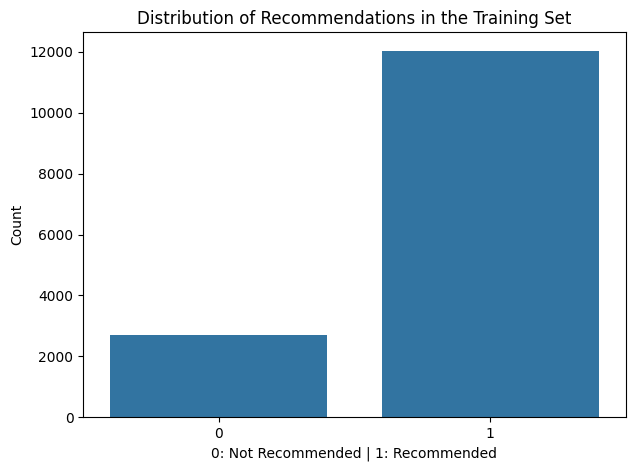

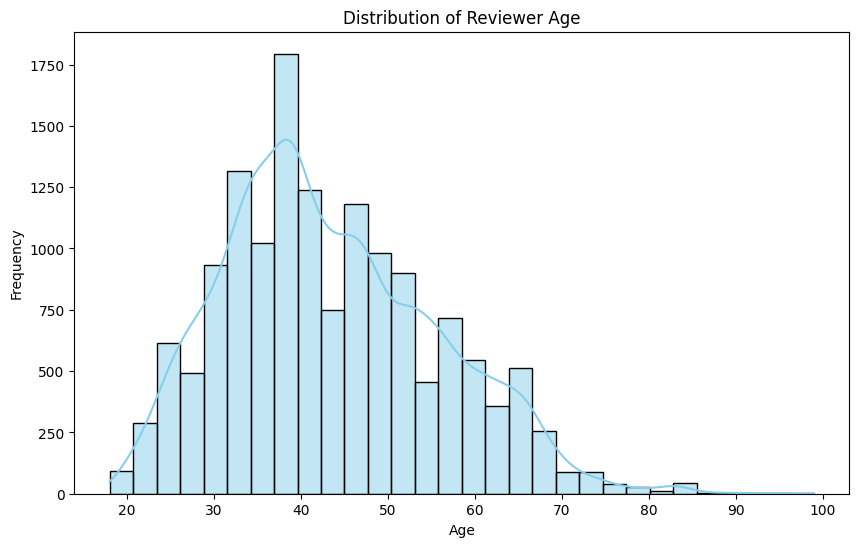

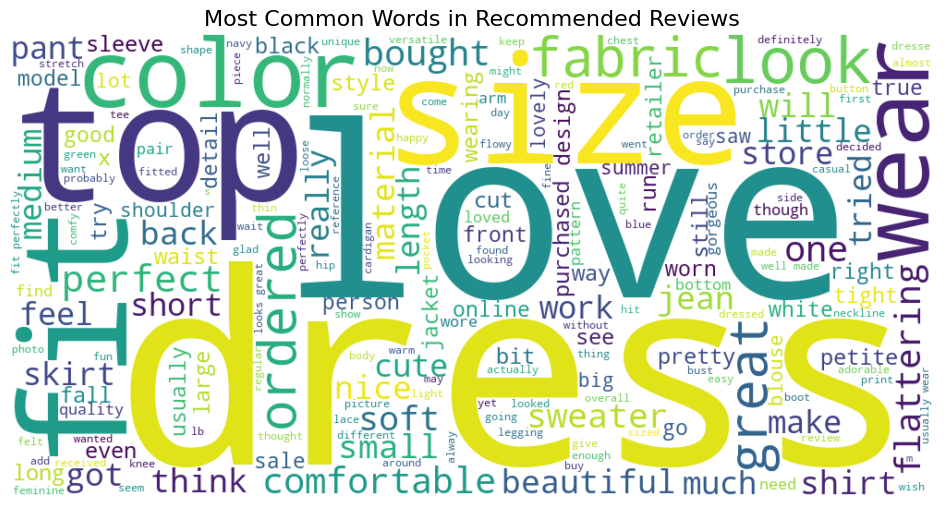

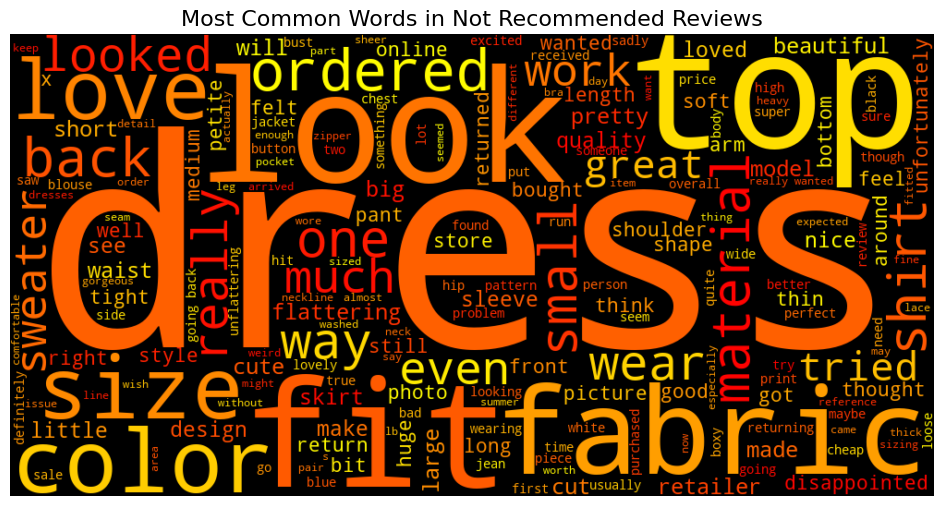

In [6]:
################################################################################
# SECTION 2: EXPLORATORY DATA ANALYSIS (EDA)
################################################################################
print("\n--- Starting Exploratory Data Analysis ---")

# --- Target Variable Distribution ---
plt.figure(figsize=(7, 5))
sns.countplot(x=y_train)
plt.title('Distribution of Recommendations in the Training Set')
plt.xlabel('0: Not Recommended | 1: Recommended')
plt.ylabel('Count')
plt.show()

# --- Age Distribution ---
plt.figure(figsize=(10, 6))
sns.histplot(X_train['Age'].dropna(), bins=30, kde=True, color="skyblue")
plt.title('Distribution of Reviewer Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

# --- Word Clouds for Text Analysis ---
recommended_text = ' '.join(X_train[y_train == 1]['Review Text'])
not_recommended_text = ' '.join(X_train[y_train == 0]['Review Text'])

# Word Cloud for Recommended Reviews
wc_recommended = WordCloud(width=1000, height=500, background_color='white').generate(recommended_text)
plt.figure(figsize=(12, 6))
plt.imshow(wc_recommended, interpolation='bilinear')
plt.title('Most Common Words in Recommended Reviews', fontsize=16)
plt.axis('off')
plt.show()

# Word Cloud for Not Recommended Reviews
wc_not_recommended = WordCloud(width=1000, height=500, background_color='black', colormap='autumn').generate(not_recommended_text)
plt.figure(figsize=(12, 6))
plt.imshow(wc_not_recommended, interpolation='bilinear')
plt.title('Most Common Words in Not Recommended Reviews', fontsize=16)
plt.axis('off')
plt.show()

## 3. Pipeline Construction (Preprocessing & Feature Engineering)

We build a robust preprocessing pipeline using `ColumnTransformer` to handle different data types (numerical, categorical, and text) appropriately. For text, we create custom transformers for lemmatization and Part-of-Speech (POS) feature extraction.

In [7]:
################################################################################
# SECTION 3: PIPELINE CONSTRUCTION (PREPROCESSING & FEATURE ENGINEERING)
################################################################################
print("\n--- Building the Preprocessing and Feature Engineering Pipeline ---")

# Load the spaCy model needed for NLP tasks.
nlp = spacy.load('en_core_web_sm')

# --- Custom Transformers for NLP ---
class SpacyLemmatizer(BaseEstimator, TransformerMixin):
    """
    A custom transformer to perform lemmatization, stop-word removal,
    and filtering for alphabetic tokens using spaCy.
    """
    def __init__(self, nlp_model):
        self.nlp_model = nlp_model
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        if not isinstance(X, pd.Series):
            X = pd.Series(X)
        return X.apply(lambda text: " ".join(
            token.lemma_ for token in self.nlp_model(text) if not token.is_stop and token.is_alpha
        ))

class PosFeatureExtractor(BaseEstimator, TransformerMixin):
    """
    A custom transformer to extract Part-of-Speech (POS) counts as features.
    Counts adjectives, nouns, and verbs in each text document.
    """
    def __init__(self, nlp_model):
        self.nlp_model = nlp_model
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        if not isinstance(X, pd.Series):
            X = pd.Series(X)
        
        pos_counts = []
        for text in X:
            doc = self.nlp_model(text)
            counts = {
                'adjective_count': len([token for token in doc if token.pos_ == 'ADJ']),
                'noun_count': len([token for token in doc if token.pos_ == 'NOUN']),
                'verb_count': len([token for token in doc if token.pos_ == 'VERB'])
            }
            pos_counts.append(counts)
        return pd.DataFrame(pos_counts)

# --- Define Feature Groups ---
num_features = ['Age', 'Positive Feedback Count']
cat_features = ['Division Name', 'Department Name', 'Class Name']
text_features = 'Review Text'

# --- Create Sub-Pipelines for Each Data Type ---
# Pipeline for numerical features: imputes missing values with the median and scales.
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler()),
])

# Pipeline for categorical features: imputes missing values with the most frequent and applies one-hot encoding.
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('cat_encoder', OneHotEncoder(sparse_output=False, handle_unknown='ignore')),
])

# Pipeline for standard text features: lemmatizes and converts to TF-IDF vectors.
text_tfidf_pipeline = Pipeline([
    ('lemmatizer', SpacyLemmatizer(nlp_model=nlp)),
    ('tfidf_vectorizer', TfidfVectorizer(max_features=1000, ngram_range=(1, 2))),
])

# Pipeline for advanced NLP features: extracts POS counts.
text_pos_pipeline = Pipeline([
    ('pos_extractor', PosFeatureExtractor(nlp_model=nlp)),
    ('scaler', MinMaxScaler()) # Scale these numerical features as well
])

# --- Combine All Preprocessing Steps with ColumnTransformer ---
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, num_features),
        ('cat', cat_pipeline, cat_features),
        ('text_tfidf', text_tfidf_pipeline, text_features),
        ('text_pos', text_pos_pipeline, text_features),
    ],
    remainder='drop' # Drop columns that were not specified (e.g., 'Title', 'Clothing ID')
)


--- Building the Preprocessing and Feature Engineering Pipeline ---


## 4. Model Training and Evaluation

Now we combine our `preprocessor` with a classifier (`RandomForestClassifier`) in a complete pipeline. We train this pipeline on the training set and evaluate its initial performance on the test set.

In [12]:
################################################################################
# SECTION 4: MODEL TRAINING AND EVALUATION
################################################################################
print("\n--- Building, Training, and Evaluating the Full Model Pipeline ---")

# --- Create the Full Model Pipeline ---
# This connects the preprocessor with the final classifier.
model_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42, n_jobs=-1, class_weight='balanced')),
])

# --- Train the Initial Model ---
model_pipeline.fit(X_train, y_train)



--- Building, Training, and Evaluating the Full Model Pipeline ---


,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [13]:
# --- Evaluate the Initial Model ---
print("\n--- Evaluating Initial Model (Before Fine-Tuning) ---")
y_pred = model_pipeline.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


--- Evaluating Initial Model (Before Fine-Tuning) ---
Accuracy: 0.8628

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.35      0.48       678
           1       0.87      0.98      0.92      3011

    accuracy                           0.86      3689
   macro avg       0.83      0.66      0.70      3689
weighted avg       0.85      0.86      0.84      3689



## 5. Model Fine-Tuning

We use `RandomizedSearchCV` to efficiently search for the best combination of hyperparameters for our pipeline, optimizing for the `f1_weighted` score. This will help us improve the model's performance, especially on the minority class.

In [9]:
################################################################################
# SECTION 5: MODEL FINE-TUNING
################################################################################
print("\n--- Fine-Tuning the Model with RandomizedSearchCV ---")

# --- Define the Hyperparameter Search Space ---
param_dist = {
    'preprocessor__text_tfidf__tfidf_vectorizer__max_df': [0.85, 0.95],
    'preprocessor__text_tfidf__tfidf_vectorizer__min_df': [1, 5, 10],
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [20, 30, None],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__max_features': ['sqrt', 'log2'],
}

# --- Set Up and Run the Randomized Search ---
# n_iter controls how many parameter combinations are tried.
# cv is the number of cross-validation folds.
random_search = RandomizedSearchCV(
    estimator=model_pipeline,
    param_distributions=param_dist,
    n_iter=15,
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1,
    scoring='f1_weighted'
)

random_search.fit(X_train, y_train)

# --- Evaluate the Best Optimized Model ---
print("\n--- Evaluating Best Model (After Fine-Tuning) ---")
best_model = random_search.best_estimator_
y_pred_best = best_model.predict(X_test)
print(f"Best Parameters Found: {random_search.best_params_}")
print(f"\nAccuracy: {accuracy_score(y_test, y_pred_best):.4f}")
print("\nClassification Report (Optimized Model):")
print(classification_report(y_test, y_pred_best))


--- Fine-Tuning the Model with RandomizedSearchCV ---
Fitting 3 folds for each of 15 candidates, totalling 45 fits

--- Evaluating Best Model (After Fine-Tuning) ---
Best Parameters Found: {'preprocessor__text_tfidf__tfidf_vectorizer__min_df': 5, 'preprocessor__text_tfidf__tfidf_vectorizer__max_df': 0.95, 'classifier__n_estimators': 300, 'classifier__min_samples_leaf': 2, 'classifier__max_features': 'log2', 'classifier__max_depth': 30}

Accuracy: 0.8574

Classification Report (Optimized Model):
              precision    recall  f1-score   support

           0       0.60      0.68      0.64       678
           1       0.93      0.90      0.91      3011

    accuracy                           0.86      3689
   macro avg       0.76      0.79      0.77      3689
weighted avg       0.87      0.86      0.86      3689



## 6. Feature Importance Visualization

To understand what factors most influence the model's predictions, we extract and visualize the most important features from our optimized RandomForest classifier.


--- Visualizing Feature Importances ---


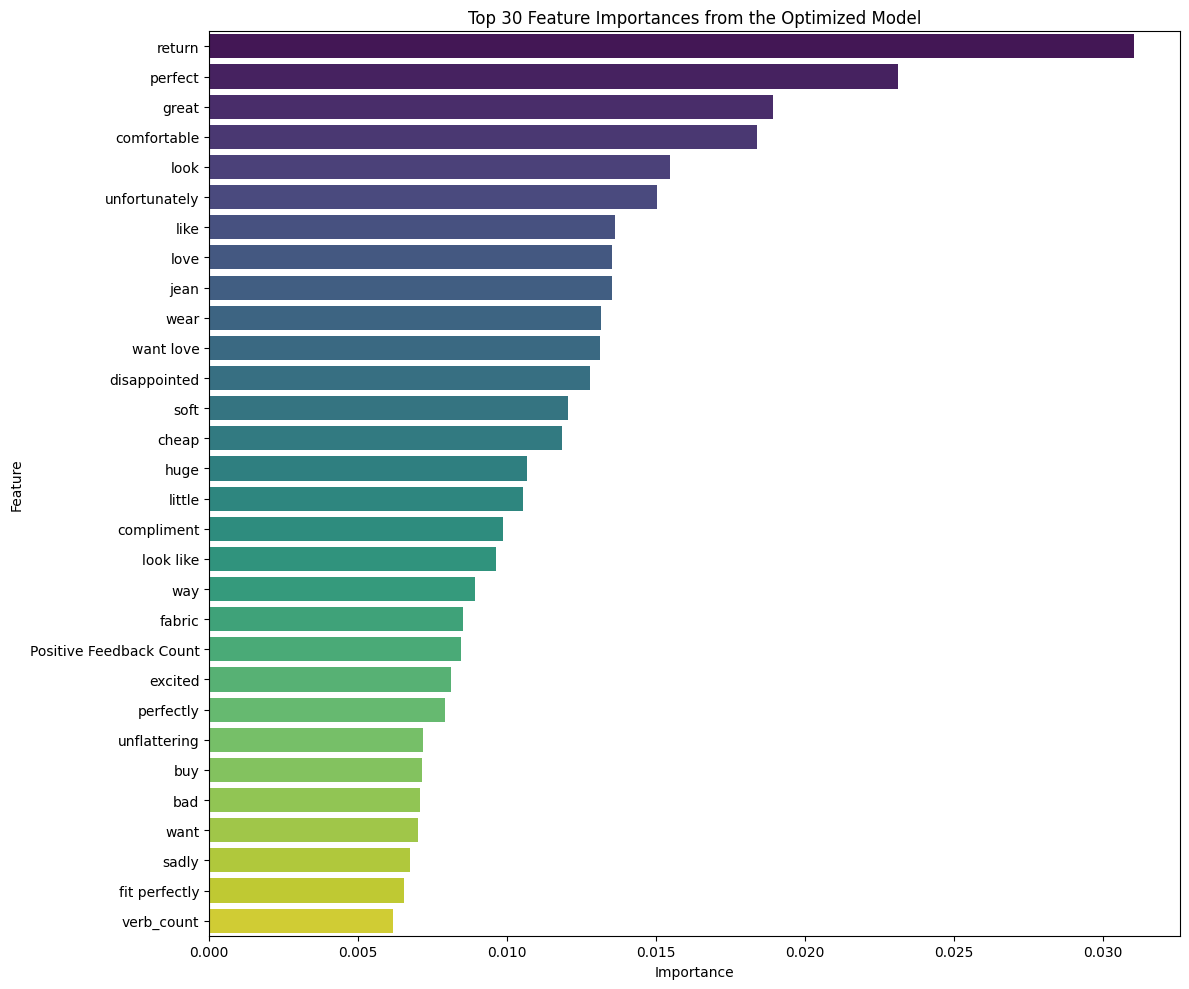

In [10]:
################################################################################
# SECTION 6: FEATURE IMPORTANCE VISUALIZATION
################################################################################
print("\n--- Visualizing Feature Importances ---")

try:
    # --- Extract Feature Names After Preprocessing ---
    cat_feature_names = best_model.named_steps['preprocessor'].named_transformers_['cat'].named_steps['cat_encoder'].get_feature_names_out(cat_features)
    tfidf_feature_names = best_model.named_steps['preprocessor'].named_transformers_['text_tfidf'].named_steps['tfidf_vectorizer'].get_feature_names_out()
    pos_feature_names = best_model.named_steps['preprocessor'].named_transformers_['text_pos'].named_steps['scaler'].get_feature_names_out(['adjective_count', 'noun_count', 'verb_count'])

    # Combine all feature names in the correct order
    all_feature_names = list(num_features) + list(cat_feature_names) + list(tfidf_feature_names) + list(pos_feature_names)
    
    # --- Get Importances and Create DataFrame ---
    importances = best_model.named_steps['classifier'].feature_importances_
    feature_importance_df = pd.DataFrame({'feature': all_feature_names, 'importance': importances})
    feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

    # --- Visualize the Top 30 Features ---
    plt.figure(figsize=(12, 10))
    sns.barplot(x='importance', y='feature', data=feature_importance_df.head(30), palette='viridis')
    plt.title('Top 30 Feature Importances from the Optimized Model')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Could not generate feature importance plot. Error: {e}")

## 7. Save the Final Model

Finally, we save the optimized model pipeline to a file `fashion_recommendation_pipeline.pkl` using `joblib`. This file can be loaded later to make predictions on new data without re-running the training.

In [11]:
################################################################################
# SECTION 7: SAVE THE FINAL MODEL
################################################################################
print("\n--- Saving the Final, Optimized Pipeline ---")

# Save the best model from the hyperparameter search to a file.
joblib.dump(best_model, 'fashion_recommendation_pipeline.pkl')
print("Pipeline saved successfully as 'fashion_recommendation_pipeline.pkl'.")


--- Saving the Final, Optimized Pipeline ---
Pipeline saved successfully as 'fashion_recommendation_pipeline.pkl'.
